In [23]:
import pandas as pd
import numpy as np
import src.data_processing.load_data
import lightgbm as lgb

In [5]:
sleep, time0 = src.data_processing.load_data.get_sleep('12/06/2021', '../../data/')

In [49]:
def prepare_data(sleep):
    infant = sleep.sleep - sleep.trend
    window = 10*24*6
    n = infant.shape[0]

    X_train = pd.DataFrame([infant.values[i : i + window] for i in range(n - window)])
    y_train = pd.DataFrame([infant.values[window + i] for i in range(n - window)])

    newsleep = sleep[window:].reset_index(drop = True)
    X_train['time_of_day'] = newsleep.time
    X_train['cos'] = newsleep.time_cos
    X_train['AM/PM'] = newsleep.ampm

    return X_train, y_train

In [25]:
def train_model(X_train, y_train):
    lgbm_reg = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1,
                              n_estimators=500, subsample_for_bin=200000, objective=None,
                              class_weight=None, min_split_gain=0.0, min_child_weight=0.001,
                              min_child_samples=20, subsample=1.0, subsample_freq=0,
                              colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=42,
                              n_jobs = -1, importance_type='split')
    lgbm_reg.fit(X_train, y_train.values.reshape(-1))

    return lgbm_reg

In [102]:
def update_step(X, model):
    step = model.predict(X)
    curr_time = X.iloc[:, -3].values[0]
    X = X.shift(-1, axis = 1)
    X[window - 1] = step
    X.index += 1

    X.iloc[:, -3] = (curr_time + 1/6) % 24
    X.iloc[:, -2] = np.cos(2 * np.pi * X.iloc[:, -3].values[0] / 24)
    if X.iloc[:, -3].values[0] > 12:
        X.iloc[:, -1] = 1
    else:
        X.iloc[:, -1] = 0

    return X

In [229]:
def forecast(sleep, time0):
    X_train, y_train = prepare_data(sleep)
    model = train_model(X_train, y_train)

    window = 10*24*6
    X = X_train[-1:]
    futuresleep = np.array(X.iloc[-1, window - 64 : window])

    m = 2*6*24
    for i in range(m):
        X = update_step(X, model).copy()
        futuresleep = np.append(futuresleep, X.iloc[-1, window - 1])

    times = pd.date_range(start = sleep.index[-65], periods = 64 + m, freq = '10min')
    answer = pd.DataFrame(data = futuresleep, index = times, columns = ['trend'])

    trend = pd.read_csv('../../data/NYU_data_processed/NYU_trend.csv', parse_dates=['timestamps'], index_col= 'timestamps')
    addtrend = pd.DataFrame(trend.trend[answer.index[0]:answer.index[-1]])
    answer = answer + addtrend
    answer.trend = (answer.trend > 0.4).astype(int)
    answer.index += time0 - answer.index[64]

    return answer

In [233]:
prd = forecast(sleep, time0)

<AxesSubplot:>

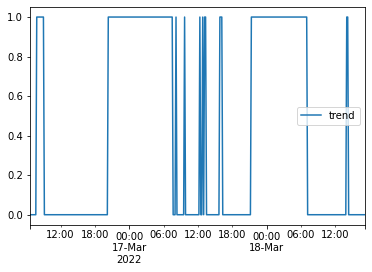

In [234]:
prd.plot()

<AxesSubplot:>

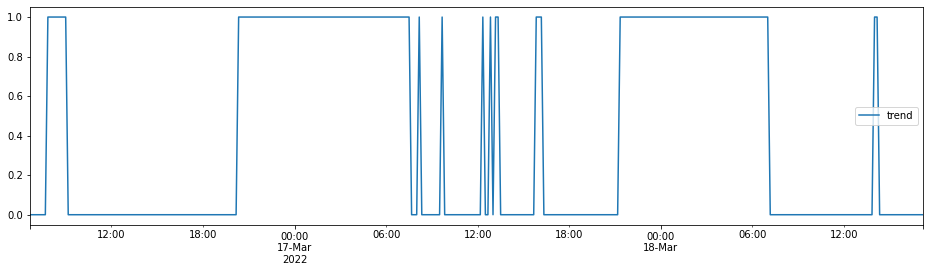

In [235]:
fig, ax = plt.subplots(figsize=(16, 4))
prd.plot(ax = ax)
fig.savefig('prediction.png')